In [88]:
import os
# os.chdir("참가자분들 각각의 데이터 경로 입력")

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

from datetime import datetime

pd.set_option('display.max_rows', 5000)

In [89]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [90]:
train['date2'] = pd.to_datetime(train['date'])
train['weekday'] = train['date2'].dt.weekday
train = pd.get_dummies(train,columns=['weekday'])
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])
del train['date2']
del test['date2']

In [91]:
train['in_out'].value_counts()
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [92]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

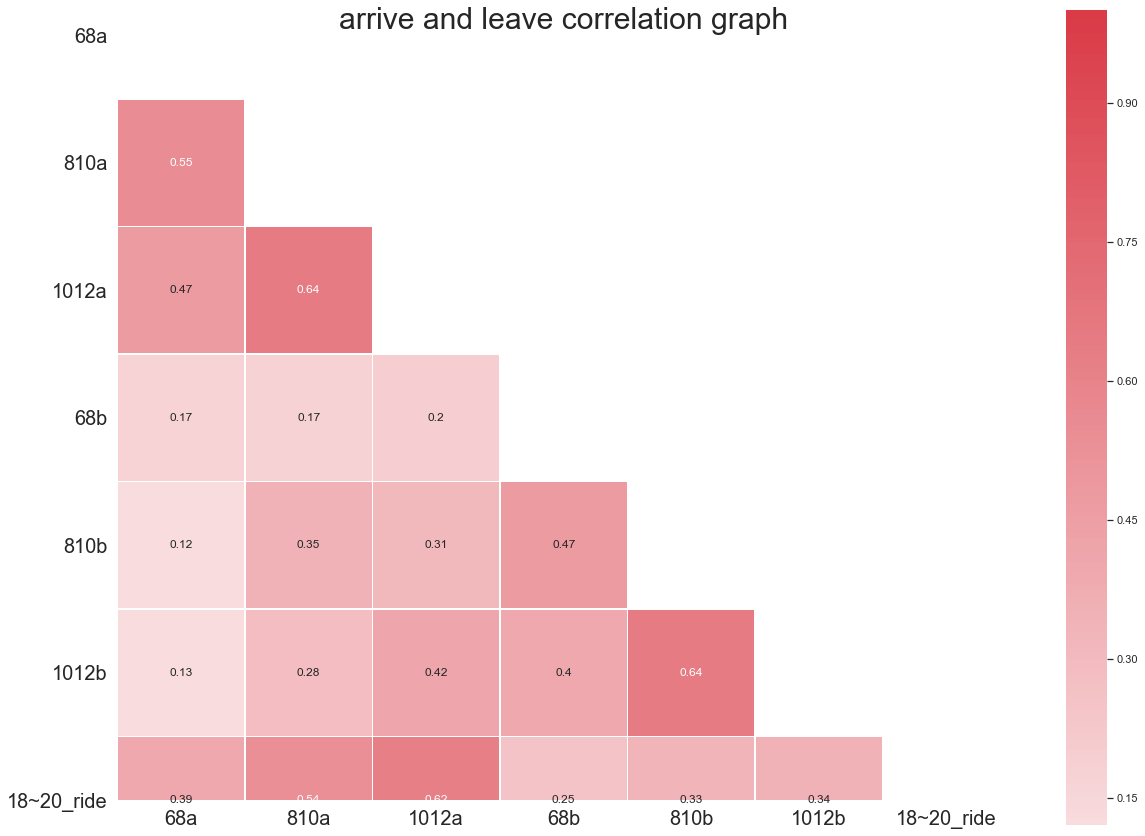

In [93]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train22.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [94]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [95]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [96]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

In [97]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [98]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({'jeju': 1479, 'po': 828, 'gosan': 659, 'seongsan': 597})

In [99]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [100]:
#데이터 불러오기
# raining=pd.read_csv("기상청데이터.csv",encoding='EUC-KR',engine='python')
raining=pd.read_csv("기상청데이터.csv",engine='python')
#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

,지점,일시,기온(°C),강수량(mm)
0,jeju,2019-09-01 00:00,23.7,NaN
1,jeju,2019-09-01 01:00,23.7,NaN
2,jeju,2019-09-01 02:00,23.5,NaN
3,jeju,2019-09-01 03:00,23.4,NaN
4,jeju,2019-09-01 04:00,23.4,NaN


In [101]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>=6) & (raining['time']<12)  ]
rain2

,지점,일시,기온(°C),강수량(mm),time
6,jeju,2019-09-01,23.4,NaN,6
7,jeju,2019-09-01,23.5,0.0,7
8,jeju,2019-09-01,24.0,0.0,8
9,jeju,2019-09-01,24.9,0.0,9
10,jeju,2019-09-01,26.2,NaN,10
11,jeju,2019-09-01,25.9,NaN,11
30,jeju,2019-09-02,23.3,0.1,6
31,jeju,2019-09-02,23.3,1.8,7
32,jeju,2019-09-02,22.3,3.9,8
33,jeju,2019-09-02,22.2,16.4,9


In [102]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)
rain3

,dist_name,date,기온(°C),강수량(mm)
0,gosan,2019-09-01,23.916667,0.000000
1,gosan,2019-09-02,23.700000,12.100000
2,gosan,2019-09-03,23.550000,1.900000
3,gosan,2019-09-04,23.533333,12.840000
4,gosan,2019-09-05,26.033333,0.000000
5,gosan,2019-09-06,27.066667,0.000000
6,gosan,2019-09-07,25.133333,0.000000
7,gosan,2019-09-08,24.383333,0.200000
8,gosan,2019-09-09,26.666667,4.750000
9,gosan,2019-09-10,26.183333,0.000000


In [103]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])
train2

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,기온(°C),강수량(mm)
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,jeju,24.650000,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,...,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,jeju,24.650000,0.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,jeju,24.650000,0.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,jeju,24.650000,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,po,23.783333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,...,0.0,0.0,0.0,27.117280,16.319339,57.465292,33.738981,gosan,23.866667,0.0
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,...,0.0,0.0,0.0,2.134693,39.904297,36.202951,28.484278,jeju,23.866667,0.0
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,...,1.0,0.0,0.0,40.039090,11.626985,60.041783,28.249863,gosan,23.866667,0.0
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,...,0.0,0.0,0.0,20.355649,23.876917,52.933244,33.392008,jeju,23.866667,0.0


In [104]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

train2.shape, test2.shape, train.shape, test.shape

((415423, 44), (228170, 43), (415423, 39), (228170, 38))

In [105]:
train2['temp'] = train2['기온(°C)']
test2['temp'] = test2['기온(°C)']
train2['rain'] = train2['강수량(mm)']
test2['rain'] = test2['강수량(mm)']
train2

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan,temp,rain
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,37.713630,27.841879,24.650000,0.0,0,1,0,0,24.650000,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,...,38.465822,27.996179,24.650000,0.0,0,1,0,0,24.650000,0.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,...,39.259820,27.496551,24.650000,0.0,0,1,0,0,24.650000,0.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,38.386802,29.579404,24.650000,0.0,0,1,0,0,24.650000,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,45.899140,14.269792,23.783333,0.0,0,0,1,0,23.783333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,...,57.465292,33.738981,23.866667,0.0,1,0,0,0,23.866667,0.0
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,...,36.202951,28.484278,23.866667,0.0,0,1,0,0,23.866667,0.0
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,...,60.041783,28.249863,23.866667,0.0,1,0,0,0,23.866667,0.0
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,...,52.933244,33.392008,23.866667,0.0,0,1,0,0,23.866667,0.0


In [106]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
#            'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)',            
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','temp', 'rain', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

In [107]:
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

X_train.shape, y_train.shape

((4154, 26), (4154, 1))

In [190]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}

start_time = datetime.now()

# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

print('grid_search time taken:',datetime.now() - start_time) # grid_search time taken: 0:02:07.198093
#해당 코드 실행시간 2분 ~ 3분 소요

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

grid_search time taken: 0:02:06.247462


{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [62]:
#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

X_train.shape, y_train.shape, X_test.shape

X_test.head()

,in_out,latitude,longitude,68a,810a,1012a,68b,810b,1012b,weekday_0,...,dis_jeju,dis_gosan,dis_seongsan,dis_po,temp,rain,dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan
0,1,33.48990,126.49373,8.0,9.0,10.0,0.0,0.0,1.0,0,...,4.286659,37.692766,37.713630,27.841879,24.766667,0.366667,0,1,0,0
1,1,33.48944,126.48508,7.0,7.0,19.0,0.0,0.0,0.0,0,...,4.966848,37.008492,38.465822,27.996179,24.766667,0.366667,0,1,0,0
2,1,33.48181,126.47352,6.0,4.0,3.0,0.0,0.0,0.0,0,...,6.330746,35.642126,39.259820,27.496551,24.766667,0.366667,0,1,0,0
3,0,33.50577,126.49252,12.0,26.0,46.0,0.0,0.0,0.0,0,...,3.575272,38.643401,38.386802,29.579404,24.766667,0.366667,0,1,0,0
4,0,33.24872,126.41032,0.0,0.0,0.0,0.0,1.0,0.0,0,...,31.460686,23.594010,46.355301,14.445605,24.683333,0.020000,0,0,1,0


In [57]:
# train 데이터내에서 다시 train: 70% , test : 30%  데이터 추출
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

def get_train_test_split(X_train, y_train, test_size=0.3, random_state=0) :
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                       test_size=test_size, random_state=random_state)
    print('X_train:',X_train.shape)
    print('X_test:',X_test.shape)
    return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.2, random_state=0)

X_train: (332338, 26)
X_test: (83085, 26)


In [54]:
# best_params_를 통해서 나온 값을 투입
# rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=500,random_state=1217)
rf = RandomForestRegressor(max_features=5,min_samples_leaf=2,min_samples_split=2,n_estimators=500,random_state=1217)

start_time = datetime.now()
print('start_time:',start_time)

rf.fit(X_train,y_train) #학습 

pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))

print('RandomForestRegressor RMSE:',rmse)   #   2.7281484722675944 <--- 2.7264889358556315

# test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

# test[['id','18~20_ride']].to_csv("2019-12-03.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다
#  2019-12-03    RMSE: 2.54572

print('RandomForestRegressor time taken:',datetime.now() - start_time) # 0:06:44.852226


start_time: 2019-12-03 10:43:03.335388


KeyboardInterrupt: 

In [58]:
# LGBMRegressor

from lightgbm import LGBMRegressor
from datetime import datetime


# X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.3, random_state=0)

lgb_reg = LGBMRegressor(n_estimators=1000)   # n_jobs (int, optional (default=-1)) – Number of parallel threads.

start_time = datetime.now()
lgb_reg.fit(X_train,y_train)
print('train time taken:',datetime.now() - start_time)   # train time taken: 0:00:15.443678  , XGBoost보다 약 16.4배 빠름

# predict using split train data
pred = lgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
print('LGBMRegressor RMSE:',rmse)   #  2.6710756031086267 <----  2.7281484722675944  개선됨

# #predict using real test data

# X_test=test2[input_var]

# test['18~20_ride'] = lgb_reg.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

# test[['id','18~20_ride']].to_csv("2019-12-03-LGBM.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다
# #  2019-12-03    RMSE: 	2.738366887    ,  감소됨

train time taken: 0:00:07.875495
LGBMRegressor RMSE: 2.5955909894825355


X_train: (203557, 26)
X_test: (87239, 26)
train time taken: 0:00:03.559136
LGBMRegressor RMSE: 2.9213447835087245


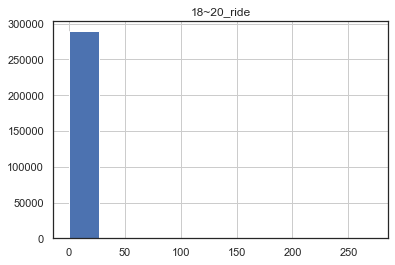

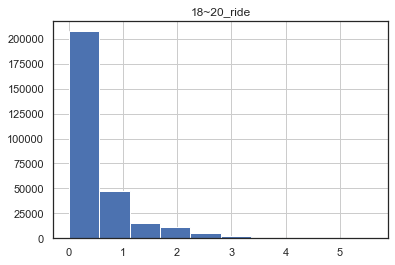

In [26]:
# 로그변환
# X_log_train = np.log1p(X_train)

y_train.hist()
y_log_train = np.log1p(y_train)
# y_log_test = np.log1p(y_test)
y_log_train.hist()

X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_log_train, test_size=0.3, random_state=0)

from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(n_estimators=500)   

start_time = datetime.now()
lgb_reg.fit(X_train,y_train)
print('train time taken:',datetime.now() - start_time)   

pred = lgb_reg.predict(X_test)

pred = np.expm1(pred)
y_test = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test,pred))
print('LGBMRegressor RMSE:',rmse)   # 2.7410777296227944 <-- 2.731863347070161   , 개선 없음

In [98]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb


def lgb_gridsearch(X_train, X_test, y_train, y_test, n_folds=3):
    '''
      LightGBM grid search cv
    '''
    param_grid = {
        'objective': ['regression'],
        'num_leaves': [15, 23, 31],
        'learning_rate': [0.1, 0.2],
        'n_estimators': [100,300,500]}

    fit_params = {
        'eval_metric': 'l2',
        'eval_set': [(X_test, y_test)],
        'verbose': False,
        'early_stopping_rounds': 10}

    # define classifier
    lgb_reg = lgb.LGBMRegressor()
    gs_reg = GridSearchCV(lgb_reg, param_grid,
                          n_jobs=1, cv=n_folds,
#                           fit_params=fit_params,
                          scoring='neg_mean_squared_error')     # important for Regression
    gs_reg.fit(X_train, y_train)

    means = gs_reg.cv_results_['mean_test_score']
    stds = gs_reg.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs_reg.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    best_parameters = gs_reg.best_params_
    print('\nbest parameters:')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    reg_best = lgb.LGBMRegressor(**best_parameters)

    return reg_best

In [113]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
#            'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)',            
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','temp', 'rain', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

X_train.shape, y_train.shape, X_test.shape

((415423, 26), (415423, 1), (228170, 26))

In [114]:
# # train 데이터내에서 다시 train: 70% , test : 30%  데이터 추출
# from sklearn.model_selection import train_test_split
# import numpy as np
# from sklearn.metrics import mean_squared_error

# def get_train_test_split(X_train, y_train, test_size=0.3, random_state=0) :
#     X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
#                                        test_size=test_size, random_state=random_state)
#     print('X_train:',X_train.shape)
#     print('X_test:',X_test.shape)
#     return  X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [116]:
import xgboost as xgb

from sklearn.model_selection import train_test_split


train_x, train_cv, y, y_cv = train_test_split(X_train,y_train, test_size=0.1, random_state=2018)

In [125]:
def XGB_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2018, num_rounds=3000):

    param = {}

    param['objective'] = 'reg:linear'

    param['eta'] = 0.05

    param['max_depth'] = 10

    param['silent'] = 1

    param['eval_metric'] = 'rmse'

    param['min_child_weight'] = 1

    param['subsample'] = 0.7

    param['colsample_bytree'] = 0.7

    param['seed'] = seed_val

    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:

        xgtest = xgb.DMatrix(test_X, label=test_y)

        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]

        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=300)

    else:

        xgtest = xgb.DMatrix(test_X)

        model = xgb.train(plst, xgtrain, num_rounds)

    return model


In [126]:
model = XGB_regressor(train_X = train_x, train_y = y, test_X = train_cv, test_y = y_cv)


[0]	train-rmse:4.60556	test-rmse:4.91146
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 300 rounds.
[1]	train-rmse:4.47293	test-rmse:4.77334
[2]	train-rmse:4.35047	test-rmse:4.64942
[3]	train-rmse:4.26208	test-rmse:4.57376
[4]	train-rmse:4.1502	test-rmse:4.46974
[5]	train-rmse:4.06506	test-rmse:4.38954
[6]	train-rmse:3.96283	test-rmse:4.28123
[7]	train-rmse:3.86837	test-rmse:4.19133
[8]	train-rmse:3.77611	test-rmse:4.10447
[9]	train-rmse:3.68898	test-rmse:4.02021
[10]	train-rmse:3.6077	test-rmse:3.94336
[11]	train-rmse:3.53417	test-rmse:3.87411
[12]	train-rmse:3.45788	test-rmse:3.79419
[13]	train-rmse:3.39478	test-rmse:3.74081
[14]	train-rmse:3.33608	test-rmse:3.69215
[15]	train-rmse:3.27242	test-rmse:3.63406
[16]	train-rmse:3.21734	test-rmse:3.58019
[17]	train-rmse:3.16504	test-rmse:3.53359
[18]	train-rmse:3.11843	test-rmse:3.48834
[19]	train-rmse:3.07426	test-rmse:3.45452
[20]	train-rmse:3.03424	test

[191]	train-rmse:1.92243	test-rmse:2.69056
[192]	train-rmse:1.92199	test-rmse:2.69087
[193]	train-rmse:1.92041	test-rmse:2.69073
[194]	train-rmse:1.91978	test-rmse:2.69019
[195]	train-rmse:1.91806	test-rmse:2.6898
[196]	train-rmse:1.91596	test-rmse:2.68953
[197]	train-rmse:1.91498	test-rmse:2.68994
[198]	train-rmse:1.91384	test-rmse:2.68966
[199]	train-rmse:1.91186	test-rmse:2.68731
[200]	train-rmse:1.91069	test-rmse:2.68699
[201]	train-rmse:1.90725	test-rmse:2.68592
[202]	train-rmse:1.90397	test-rmse:2.68452
[203]	train-rmse:1.9008	test-rmse:2.68349
[204]	train-rmse:1.89931	test-rmse:2.68271
[205]	train-rmse:1.89817	test-rmse:2.68254
[206]	train-rmse:1.89637	test-rmse:2.68192
[207]	train-rmse:1.89353	test-rmse:2.68097
[208]	train-rmse:1.89206	test-rmse:2.6805
[209]	train-rmse:1.89006	test-rmse:2.67933
[210]	train-rmse:1.88808	test-rmse:2.67898
[211]	train-rmse:1.88592	test-rmse:2.67966
[212]	train-rmse:1.88499	test-rmse:2.67934
[213]	train-rmse:1.88341	test-rmse:2.67912
[214]	train-rm

[383]	train-rmse:1.66376	test-rmse:2.64481
[384]	train-rmse:1.66291	test-rmse:2.64457
[385]	train-rmse:1.66188	test-rmse:2.64463
[386]	train-rmse:1.66041	test-rmse:2.64489
[387]	train-rmse:1.65934	test-rmse:2.64451
[388]	train-rmse:1.6588	test-rmse:2.64467
[389]	train-rmse:1.65719	test-rmse:2.64435
[390]	train-rmse:1.65681	test-rmse:2.64438
[391]	train-rmse:1.65543	test-rmse:2.64424
[392]	train-rmse:1.65409	test-rmse:2.64446
[393]	train-rmse:1.65225	test-rmse:2.64468
[394]	train-rmse:1.65095	test-rmse:2.64445
[395]	train-rmse:1.64961	test-rmse:2.6443
[396]	train-rmse:1.64905	test-rmse:2.64428
[397]	train-rmse:1.64819	test-rmse:2.6442
[398]	train-rmse:1.64712	test-rmse:2.644
[399]	train-rmse:1.64544	test-rmse:2.64382
[400]	train-rmse:1.64407	test-rmse:2.64342
[401]	train-rmse:1.6429	test-rmse:2.64353
[402]	train-rmse:1.64181	test-rmse:2.6441
[403]	train-rmse:1.64115	test-rmse:2.64404
[404]	train-rmse:1.64035	test-rmse:2.64386
[405]	train-rmse:1.63998	test-rmse:2.64364
[406]	train-rmse:1

[575]	train-rmse:1.48561	test-rmse:2.6358
[576]	train-rmse:1.48495	test-rmse:2.63591
[577]	train-rmse:1.48449	test-rmse:2.63594
[578]	train-rmse:1.48363	test-rmse:2.63588
[579]	train-rmse:1.48295	test-rmse:2.63595
[580]	train-rmse:1.48223	test-rmse:2.63584
[581]	train-rmse:1.48141	test-rmse:2.6358
[582]	train-rmse:1.48055	test-rmse:2.63604
[583]	train-rmse:1.4797	test-rmse:2.63612
[584]	train-rmse:1.47873	test-rmse:2.63589
[585]	train-rmse:1.47758	test-rmse:2.63566
[586]	train-rmse:1.47653	test-rmse:2.63551
[587]	train-rmse:1.47593	test-rmse:2.63551
[588]	train-rmse:1.47503	test-rmse:2.63547
[589]	train-rmse:1.47402	test-rmse:2.63559
[590]	train-rmse:1.47349	test-rmse:2.63564
[591]	train-rmse:1.47249	test-rmse:2.63579
[592]	train-rmse:1.47168	test-rmse:2.63561
[593]	train-rmse:1.47122	test-rmse:2.63577
[594]	train-rmse:1.46996	test-rmse:2.63607
[595]	train-rmse:1.46917	test-rmse:2.63577
[596]	train-rmse:1.46892	test-rmse:2.63576
[597]	train-rmse:1.46842	test-rmse:2.6357
[598]	train-rms

[767]	train-rmse:1.35031	test-rmse:2.6363
[768]	train-rmse:1.34977	test-rmse:2.63619
[769]	train-rmse:1.34898	test-rmse:2.636
[770]	train-rmse:1.34865	test-rmse:2.63589
[771]	train-rmse:1.348	test-rmse:2.63595
[772]	train-rmse:1.34747	test-rmse:2.6358
[773]	train-rmse:1.3472	test-rmse:2.63579
[774]	train-rmse:1.34641	test-rmse:2.63564
[775]	train-rmse:1.34575	test-rmse:2.63585
[776]	train-rmse:1.34539	test-rmse:2.63583
[777]	train-rmse:1.34468	test-rmse:2.63593
[778]	train-rmse:1.34375	test-rmse:2.63606
[779]	train-rmse:1.34301	test-rmse:2.63613
[780]	train-rmse:1.34257	test-rmse:2.63587
[781]	train-rmse:1.34161	test-rmse:2.63585
[782]	train-rmse:1.34087	test-rmse:2.63595
[783]	train-rmse:1.34049	test-rmse:2.63591
[784]	train-rmse:1.33985	test-rmse:2.63572
[785]	train-rmse:1.33901	test-rmse:2.63593
[786]	train-rmse:1.33832	test-rmse:2.63591
[787]	train-rmse:1.33749	test-rmse:2.63596
[788]	train-rmse:1.33695	test-rmse:2.63599
[789]	train-rmse:1.33642	test-rmse:2.63602
[790]	train-rmse:1

[959]	train-rmse:1.2466	test-rmse:2.64087
[960]	train-rmse:1.24617	test-rmse:2.64089
[961]	train-rmse:1.24555	test-rmse:2.64098
[962]	train-rmse:1.24472	test-rmse:2.64076
[963]	train-rmse:1.2443	test-rmse:2.64079
[964]	train-rmse:1.24351	test-rmse:2.64087
[965]	train-rmse:1.24284	test-rmse:2.64081
[966]	train-rmse:1.24238	test-rmse:2.64091
[967]	train-rmse:1.24194	test-rmse:2.64098
[968]	train-rmse:1.24129	test-rmse:2.64102
[969]	train-rmse:1.24105	test-rmse:2.64099
[970]	train-rmse:1.24082	test-rmse:2.64085
[971]	train-rmse:1.24041	test-rmse:2.64084
[972]	train-rmse:1.23994	test-rmse:2.64081
[973]	train-rmse:1.23939	test-rmse:2.64079
[974]	train-rmse:1.23897	test-rmse:2.64073
[975]	train-rmse:1.23822	test-rmse:2.64079
[976]	train-rmse:1.23785	test-rmse:2.64077
Stopping. Best iteration:
[676]	train-rmse:1.41117	test-rmse:2.63409



In [133]:
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

pred = model.predict(xgb.DMatrix(X_train), ntree_limit = model.best_ntree_limit)
rmse = np.sqrt(mean_squared_error(y_train,pred))
print('XGBRegressor RMSE:',rmse)    #  1.5767431432114971 , 과적합  -->  제출 스코어  : 2.604389141 

XGBRegressor RMSE: 1.5767431432114971


In [134]:
test['18~20_ride'] = model.predict(xgb.DMatrix(X_test), ntree_limit = model.best_ntree_limit)
#예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("2019-12-04_XGBRegressor.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

In [136]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

now = datetime.datetime.now()


X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]


# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

In [111]:

from xgboost import XGBRegressor
from datetime import datetime

xgb_reg = XGBRegressor(n_estimators=1000,n_jobs= -1)   # train time taken: 0:05:28.379372

# xgb_reg = XGBRegressor(n_estimators=1000,n_jobs= 1)  #  train time taken: 0:06:25.042153

start_time = datetime.now()
xgb_reg.fit(X_train,y_train)

print('train time taken:',datetime.now() - start_time)

pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
print('XGBRegressor RMSE:',rmse)    #  2.9114352000920913

[09:27:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train time taken: 0:02:15.047764
XGBRegressor RMSE: 2.8511535587319328


In [100]:
# # LGBM best params_1203.txt 공유폴더에 있는 파일 사용

# lgbm_best = LGBMRegressor(random_state=1251, lambda_l1= 10, lambda_l2= 0.05, learning_rate= 0.1, max_depth= 6, min_data_in_leaf= 30, 
#                           n_estimators= 300, n_jobs= -1, num_leaves= 60, subsample= 0.4)

# X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# # Re-fit
# lgbm_best.fit(X_train, y_train, 
#                 eval_metric='l2',
#                 eval_set=[(X_test, y_test)],
#                 early_stopping_rounds=10)

# y_pred = lgbm_best.predict(X_test, num_iteration=lgb_reg.best_iteration_)
# mse = mean_squared_error(y_test, y_pred)

# rmse = np.sqrt(mse)
# print('\nRMSE = ', rmse)  # 2.7021602560954023  --> RMSE =  2.9206608998201444  

In [101]:
X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.3, random_state=0)
lgb_reg = lgb_gridsearch(X_train, X_test, y_train, y_test, n_folds=5)
lgb_reg


X_train: (290796, 26)
X_test: (124627, 26)
-8.567 (+/-0.977) for {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 15, 'objective': 'regression'}
-8.252 (+/-0.939) for {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 23, 'objective': 'regression'}
-8.169 (+/-0.872) for {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31, 'objective': 'regression'}
-8.012 (+/-0.854) for {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 15, 'objective': 'regression'}
-7.777 (+/-0.909) for {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 23, 'objective': 'regression'}
-7.687 (+/-0.834) for {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 31, 'objective': 'regression'}
-7.796 (+/-0.815) for {'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 15, 'objective': 'regression'}
-7.613 (+/-0.866) for {'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 23, 'objective': 'regression'}
-7.542 (+/-0.831) for {'learning_rate': 0.1, 'n_estimators': 500, 'nu

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [102]:
# Re-fit
lgb_reg.fit(X_train, y_train, 
                eval_metric='l2',
                eval_set=[(X_test, y_test)],
                early_stopping_rounds=10)

y_pred = lgb_reg.predict(X_test, num_iteration=lgb_reg.best_iteration_)
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
print('\nRMSE = ', rmse)  # 2.7021602560954023

[1]	valid_0's l2: 19.6648
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 18.005
[3]	valid_0's l2: 16.671
[4]	valid_0's l2: 15.464
[5]	valid_0's l2: 14.5405
[6]	valid_0's l2: 13.7139
[7]	valid_0's l2: 12.982
[8]	valid_0's l2: 12.4174
[9]	valid_0's l2: 11.9357
[10]	valid_0's l2: 11.511
[11]	valid_0's l2: 11.1589
[12]	valid_0's l2: 10.8461
[13]	valid_0's l2: 10.634
[14]	valid_0's l2: 10.4244
[15]	valid_0's l2: 10.2139
[16]	valid_0's l2: 10.0745
[17]	valid_0's l2: 9.94399
[18]	valid_0's l2: 9.79711
[19]	valid_0's l2: 9.68478
[20]	valid_0's l2: 9.59838
[21]	valid_0's l2: 9.48731
[22]	valid_0's l2: 9.40631
[23]	valid_0's l2: 9.32194
[24]	valid_0's l2: 9.2564
[25]	valid_0's l2: 9.17133
[26]	valid_0's l2: 9.1356
[27]	valid_0's l2: 9.08731
[28]	valid_0's l2: 9.02729
[29]	valid_0's l2: 8.96632
[30]	valid_0's l2: 8.92475
[31]	valid_0's l2: 8.8943
[32]	valid_0's l2: 8.85267
[33]	valid_0's l2: 8.82012
[34]	valid_0's l2: 8.77553
[35]	valid_0's l2: 8.73266
[36]	valid_0

[304]	valid_0's l2: 7.43768
[305]	valid_0's l2: 7.4376
[306]	valid_0's l2: 7.43846
[307]	valid_0's l2: 7.4388
[308]	valid_0's l2: 7.4397
[309]	valid_0's l2: 7.43754
[310]	valid_0's l2: 7.43752
[311]	valid_0's l2: 7.43675
[312]	valid_0's l2: 7.43436
[313]	valid_0's l2: 7.42999
[314]	valid_0's l2: 7.43028
[315]	valid_0's l2: 7.42804
[316]	valid_0's l2: 7.43527
[317]	valid_0's l2: 7.42859
[318]	valid_0's l2: 7.42462
[319]	valid_0's l2: 7.42603
[320]	valid_0's l2: 7.42805
[321]	valid_0's l2: 7.42591
[322]	valid_0's l2: 7.42139
[323]	valid_0's l2: 7.41952
[324]	valid_0's l2: 7.42003
[325]	valid_0's l2: 7.41777
[326]	valid_0's l2: 7.41725
[327]	valid_0's l2: 7.41678
[328]	valid_0's l2: 7.41389
[329]	valid_0's l2: 7.41094
[330]	valid_0's l2: 7.41016
[331]	valid_0's l2: 7.41074
[332]	valid_0's l2: 7.41004
[333]	valid_0's l2: 7.40959
[334]	valid_0's l2: 7.40771
[335]	valid_0's l2: 7.40631
[336]	valid_0's l2: 7.40653
[337]	valid_0's l2: 7.40733
[338]	valid_0's l2: 7.41081
[339]	valid_0's l2: 7.4

In [81]:
#  To submit the result 
# X_train=train2[input_var]
# y_train=train2[target]

X_test=test2[input_var]

# lgb_reg = lgb_gridsearch(X_train, X_test, y_train, y_test, n_folds=5)

# # Re-fit
# lgb_reg.fit(X_train, y_train, 
#                 eval_metric='l2',
#                 eval_set=[(X_test, y_test)],
#                 early_stopping_rounds=10)


test['18~20_ride'] =  lgb_reg.predict(X_test, num_iteration=lgb_reg.best_iteration_)
#예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("2019-12-03_lgb_best.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다


7~8_ride         0.371751
8~9_ride         0.445316
9~10_ride        0.494085
10~11_ride       0.512666
11~12_ride       0.569747
11~12_takeoff    0.313540
18~20_ride       1.000000
68a              0.394406
810a             0.538263
1012a            0.616721
810b             0.334714
1012b            0.344370
Name: 18~20_ride, dtype: float64


AttributeError: 'Operation' object has no attribute 'shape'

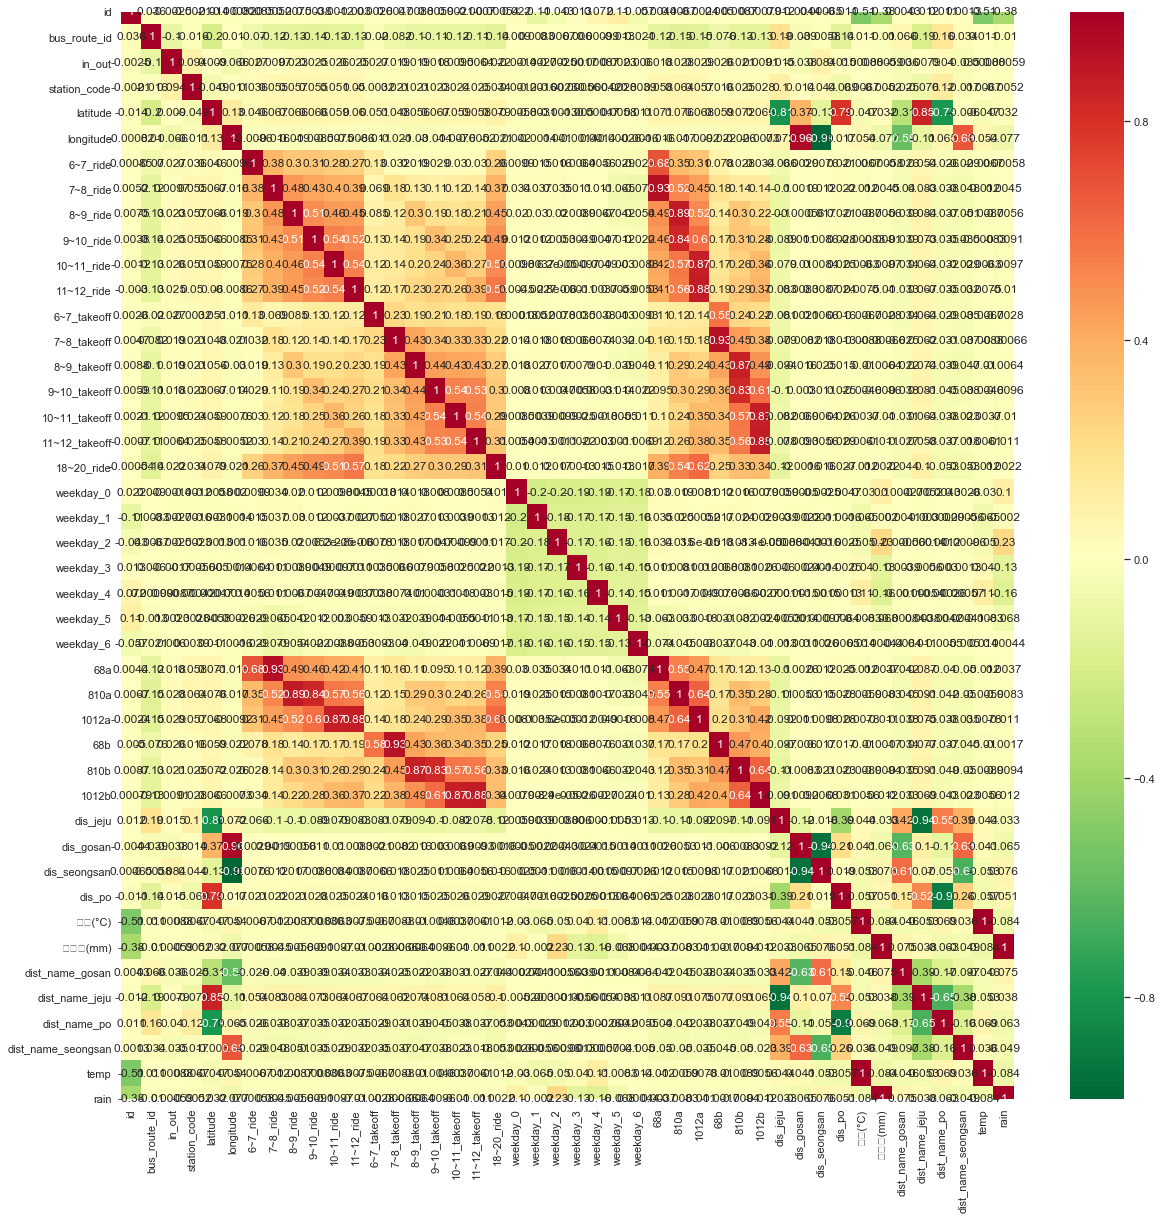

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
df = train2
df_corr = df.corr()
print(df_corr[df_corr['18~20_ride'] > 0.3]['18~20_ride'])

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(df_corr,cmap='RdYlGn_r', annot=True)
# train.shape

In [26]:
#  pip install --upgrade tensorflow==1.14.0 

import tensorflow as tf

tf.set_random_seed(777)

# x_data : [5,3]
x_data = [[73.,80.,75.],
          [93.,88.,93.],
          [89.,91.,90.],
          [96.,98.,100.],
          [73.,66.,70.]]
# y_data : [5,1]
y_data = [[152.],
          [185.],
          [180.],
          [196.],
          [142.]]

X = tf.placeholder(tf.float32,shape=[None,3])
Y = tf.placeholder(tf.float32,shape=[None,1])

W = tf.Variable(tf.random_normal([3,1]),name='weight')
b = tf.Variable(tf.random_normal([1]),name='bias')

hypothesis = tf.matmul(X, W)  +  b

cost = tf.reduce_mean(tf.square(hypothesis - Y))

optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-5 )
train = optimizer.minimize((cost))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(50001) :
    # cost_val,hyp_val,_ = \
    #     sess.run([cost,hypothesis,train],\
    #              feed_dict = { X:x_data,Y:y_data})
    # if step % 20 == 0 :
    #     print(step,cost_val,hyp_val)

    cost_val,W_val,b_val,_ = \
        sess.run([cost,W,b,train],\
                 feed_dict = { X:x_data,Y:y_data})

    if step % 20 == 0 :
        print(step,cost_val,W_val,b_val)


# predict : test model
x_data = [[73.,80.,75.],
          [93.,88.,93.],
          [89.,91.,90.],
          [96.,98.,100.],
          [73.,66.,70.]]

pred = sess.run(hypothesis,feed_dict= {X:x_data})
print('pridect:\n',pred)
print('y_data:\n',y_data)

rmse = np.sqrt(mean_squared_error(y_data,pred))
print('\nrmse = ', rmse)

0 34475.734 [[ 0.5772391 ]
 [-0.95569134]
 [ 1.1450297 ]] [1.6625803]
20 14.064138 [[ 0.9773382 ]
 [-0.54886526]
 [ 1.5515403 ]] [1.6672977]
40 13.92722 [[ 0.974414 ]
 [-0.5446998]
 [ 1.550328 ]] [1.6673287]
60 13.791763 [[ 0.9715034]
 [-0.5405599]
 [ 1.5491166]] [1.6673597]
80 13.657704 [[ 0.96860987]
 [-0.5364417 ]
 [ 1.5479097 ]] [1.6673907]
100 13.525205 [[ 0.9657333]
 [-0.5323452]
 [ 1.5467075]] [1.6674217]
120 13.394053 [[ 0.9628737]
 [-0.5282702]
 [ 1.5455097]] [1.6674527]
140 13.2643 [[ 0.9600308 ]
 [-0.52421653]
 [ 1.5443164 ]] [1.6674837]
160 13.135933 [[ 0.95720464]
 [-0.52018404]
 [ 1.5431275 ]] [1.6675147]
180 13.008931 [[ 0.954395 ]
 [-0.5161725]
 [ 1.5419432]] [1.6675457]
200 12.883273 [[ 0.951602 ]
 [-0.5121821]
 [ 1.5407631]] [1.6675767]
220 12.758994 [[ 0.9488255]
 [-0.5082128]
 [ 1.5395876]] [1.6676077]
240 12.636038 [[ 0.9460653]
 [-0.5042642]
 [ 1.5384164]] [1.6676387]
260 12.514387 [[ 0.94332135]
 [-0.5003363 ]
 [ 1.5372496 ]] [1.6676697]
280 12.394012 [[ 0.940593

2620 4.3993087 [[ 0.7123524 ]
 [-0.15506133]
 [ 1.4245491 ]] [1.6718811]
2640 4.3649864 [[ 0.71102744]
 [-0.15294315]
 [ 1.4237666 ]] [1.6719192]
2660 4.3310747 [[ 0.7097108 ]
 [-0.15083577]
 [ 1.4229866 ]] [1.6719574]
2680 4.297496 [[ 0.70840263]
 [-0.14873911]
 [ 1.4222088 ]] [1.6719955]
2700 4.264272 [[ 0.70710266]
 [-0.14665323]
 [ 1.4214336 ]] [1.6720337]
2720 4.231372 [[ 0.7058112 ]
 [-0.14457794]
 [ 1.4206604 ]] [1.6720718]
2740 4.198834 [[ 0.7045279 ]
 [-0.14251319]
 [ 1.4198895 ]] [1.67211]
2760 4.166621 [[ 0.7032528]
 [-0.1404591]
 [ 1.419121 ]] [1.6721481]
2780 4.134787 [[ 0.70198596]
 [-0.1384154 ]
 [ 1.4183547 ]] [1.6721863]
2800 4.103219 [[ 0.70072705]
 [-0.13638213]
 [ 1.4175909 ]] [1.6722244]
2820 4.0720387 [[ 0.6994764 ]
 [-0.13435915]
 [ 1.416829  ]] [1.672263]
2840 4.0411572 [[ 0.69823366]
 [-0.13234651]
 [ 1.4160694 ]] [1.6723036]
2860 4.0106072 [[ 0.69699895]
 [-0.13034403]
 [ 1.415312  ]] [1.6723441]
2880 3.980362 [[ 0.6957722 ]
 [-0.12835184]
 [ 1.414557  ]] [1.6

5340 1.8815416 [[0.59359145]
 [0.05383779]
 [1.335589  ]] [1.6774259]
5360 1.8729242 [[0.5930758 ]
 [0.05491044]
 [1.3350393 ]] [1.6774688]
5380 1.8644106 [[0.5925638 ]
 [0.05597766]
 [1.3344908 ]] [1.6775117]
5400 1.8559711 [[0.592056  ]
 [0.05703989]
 [1.3339434 ]] [1.6775546]
5420 1.8475968 [[0.591552  ]
 [0.05809684]
 [1.3333973 ]] [1.6775975]
5440 1.8393307 [[0.591052  ]
 [0.05914884]
 [1.3328521 ]] [1.6776404]
5460 1.8311249 [[0.5905557 ]
 [0.06019555]
 [1.3323085 ]] [1.6776834]
5480 1.8230066 [[0.5900636 ]
 [0.06123744]
 [1.3317659 ]] [1.6777263]
5500 1.8149694 [[0.58957493]
 [0.06227402]
 [1.3312246 ]] [1.6777692]
5520 1.806991 [[0.5890903 ]
 [0.06330584]
 [1.3306843 ]] [1.6778121]
5540 1.7991005 [[0.5886094]
 [0.0643324]
 [1.3301454]] [1.677855]
5560 1.7912846 [[0.58813244]
 [0.06535427]
 [1.3296072 ]] [1.6778979]
5580 1.7835448 [[0.587659  ]
 [0.06637093]
 [1.3290708 ]] [1.6779408]
5600 1.7758808 [[0.5871896 ]
 [0.06738293]
 [1.3285348 ]] [1.6779838]
5620 1.7682734 [[0.586723

8220 1.1885254 [[0.5512808 ]
 [0.16603835]
 [1.2665422 ]] [1.6836057]
8240 1.1860459 [[0.5511591]
 [0.166587 ]
 [1.2661202]] [1.6836486]
8260 1.1835831 [[0.55103934]
 [0.16713342]
 [1.2656984 ]] [1.6836915]
8280 1.1811233 [[0.550921  ]
 [0.16767727]
 [1.2652779 ]] [1.6837344]
8300 1.178703 [[0.55080444]
 [0.16821857]
 [1.2648581 ]] [1.6837773]
8320 1.1762977 [[0.5506897 ]
 [0.16875768]
 [1.2644385 ]] [1.6838202]
8340 1.1739165 [[0.5505769 ]
 [0.16929455]
 [1.2640194 ]] [1.6838632]
8360 1.1715539 [[0.5504655 ]
 [0.16982889]
 [1.2636014 ]] [1.6839061]
8380 1.1691821 [[0.5503558 ]
 [0.17036076]
 [1.2631842 ]] [1.683949]
8400 1.1668521 [[0.5502479 ]
 [0.17089051]
 [1.262767  ]] [1.6839919]
8420 1.1645191 [[0.55014193]
 [0.17141816]
 [1.2623503 ]] [1.6840348]
8440 1.1622099 [[0.5500374 ]
 [0.17194311]
 [1.2619348 ]] [1.6840777]
8460 1.159929 [[0.5499344 ]
 [0.17246585]
 [1.2615199 ]] [1.6841207]
8480 1.1576507 [[0.54983336]
 [0.17298648]
 [1.2611051 ]] [1.6841636]
8500 1.1553895 [[0.549734 

11000 0.9582094 [[0.54759943]
 [0.22386982]
 [1.2130058 ]] [1.6893212]
11020 0.95707333 [[0.54764664]
 [0.22418028]
 [1.2126521 ]] [1.6893617]
11040 0.9559457 [[0.54769444]
 [0.22448944]
 [1.212299  ]] [1.6894022]
11060 0.9548348 [[0.5477432 ]
 [0.22479747]
 [1.2119461 ]] [1.6894428]
11080 0.9537117 [[0.5477929 ]
 [0.22510456]
 [1.2115933 ]] [1.6894833]
11100 0.95262444 [[0.5478436]
 [0.2254107]
 [1.2112404]] [1.6895238]
11120 0.95151013 [[0.54789484]
 [0.22571564]
 [1.2108883 ]] [1.6895643]
11140 0.9504131 [[0.54794663]
 [0.22601926]
 [1.2105367 ]] [1.6896049]
11160 0.9493042 [[0.5479991 ]
 [0.22632158]
 [1.2101859 ]] [1.6896454]
11180 0.9482158 [[0.5480523]
 [0.2266227]
 [1.2098354]] [1.689686]
11200 0.9471243 [[0.54810643]
 [0.22692293]
 [1.2094849 ]] [1.6897265]
11220 0.94604415 [[0.5481615 ]
 [0.22722219]
 [1.2091345 ]] [1.689767]
11240 0.9449617 [[0.54821736]
 [0.22752047]
 [1.2087842 ]] [1.6898075]
11260 0.9438845 [[0.5482737]
 [0.2278175]
 [1.2084347]] [1.6898481]
11280 0.94281

13560 0.84032834 [[0.55862814]
 [0.25593072]
 [1.1703843 ]] [1.6944362]
13580 0.8395667 [[0.55874467]
 [0.25613222]
 [1.1700696 ]] [1.6944743]
13600 0.8387926 [[0.55886155]
 [0.2563333 ]
 [1.1697551 ]] [1.6945125]
13620 0.8380221 [[0.5589787 ]
 [0.25653368]
 [1.169441  ]] [1.6945506]
13640 0.8372499 [[0.55909616]
 [0.25673342]
 [1.1691273 ]] [1.6945888]
13660 0.83649033 [[0.5592139 ]
 [0.25693232]
 [1.1688141 ]] [1.6946269]
13680 0.83571833 [[0.55933183]
 [0.25713056]
 [1.1685013 ]] [1.6946651]
13700 0.8349513 [[0.5594499 ]
 [0.25732833]
 [1.1681887 ]] [1.6947032]
13720 0.8341974 [[0.5595685 ]
 [0.25752553]
 [1.1678764 ]] [1.6947414]
13740 0.8334385 [[0.55968755]
 [0.2577221 ]
 [1.167564  ]] [1.6947795]
13760 0.83267707 [[0.55980694]
 [0.2579184 ]
 [1.1672517 ]] [1.6948177]
13780 0.8319246 [[0.55992687]
 [0.25811413]
 [1.1669394 ]] [1.6948558]
13800 0.83117694 [[0.56004715]
 [0.25830933]
 [1.1666273 ]] [1.694894]
13820 0.8304182 [[0.56016755]
 [0.25850394]
 [1.1663157 ]] [1.6949321]
13

16240 0.74804723 [[0.576522  ]
 [0.27855778]
 [1.1302928 ]] [1.6995459]
16260 0.74741614 [[0.5766682 ]
 [0.27870008]
 [1.1300071 ]] [1.6995816]
16280 0.74680936 [[0.5768146]
 [0.2788421]
 [1.1297219]] [1.6996174]
16300 0.7461839 [[0.576961  ]
 [0.27898368]
 [1.129437  ]] [1.6996531]
16320 0.745554 [[0.5771073]
 [0.2791248]
 [1.1291524]] [1.6996889]
16340 0.74493945 [[0.57725376]
 [0.2792656 ]
 [1.1288683 ]] [1.6997247]
16360 0.74432164 [[0.57740027]
 [0.2794062 ]
 [1.1285844 ]] [1.6997604]
16380 0.74371636 [[0.57754683]
 [0.27954626]
 [1.1283007 ]] [1.6997962]
16400 0.743097 [[0.57769346]
 [0.2796863 ]
 [1.128017  ]] [1.699832]
16420 0.7424798 [[0.5778403 ]
 [0.27982616]
 [1.1277332 ]] [1.6998677]
16440 0.7418658 [[0.57798755]
 [0.27996564]
 [1.1274495 ]] [1.6999035]
16460 0.7412493 [[0.578135  ]
 [0.28010494]
 [1.1271658 ]] [1.6999393]
16480 0.7406436 [[0.5782828 ]
 [0.28024393]
 [1.1268821 ]] [1.699975]
16500 0.7400243 [[0.57843053]
 [0.28038272]
 [1.1265985 ]] [1.7000108]
16520 0.73

18960 0.66998804 [[0.59713286]
 [0.29553726]
 [1.0930953 ]] [1.7044096]
18980 0.6694525 [[0.5972877 ]
 [0.29564753]
 [1.092833  ]] [1.7044454]
19000 0.6689151 [[0.59744245]
 [0.29575765]
 [1.0925708 ]] [1.7044811]
19020 0.66839516 [[0.59759736]
 [0.29586777]
 [1.0923085 ]] [1.7045169]
19040 0.6678618 [[0.59775233]
 [0.29597777]
 [1.0920463 ]] [1.7045527]
19060 0.6673318 [[0.5979073 ]
 [0.29608774]
 [1.091784  ]] [1.7045884]
19080 0.6667989 [[0.5980623]
 [0.2961976]
 [1.091522 ]] [1.7046242]
19100 0.66628104 [[0.5982172 ]
 [0.29630727]
 [1.0912602 ]] [1.7046599]
19120 0.66574854 [[0.59837216]
 [0.29641664]
 [1.0909984 ]] [1.7046957]
19140 0.6652211 [[0.59852713]
 [0.2965258 ]
 [1.0907371 ]] [1.7047315]
19160 0.6646813 [[0.598682  ]
 [0.29663476]
 [1.090476  ]] [1.7047672]
19180 0.6641749 [[0.59883684]
 [0.29674342]
 [1.0902152 ]] [1.704803]
19200 0.6636341 [[0.5989917]
 [0.2968519]
 [1.0899547]] [1.7048388]
19220 0.6631152 [[0.59914654]
 [0.29696006]
 [1.0896944 ]] [1.7048745]
19240 0.6

21280 0.6118841 [[0.61509305]
 [0.30736908]
 [1.0636122 ]] [1.7083398]
21300 0.6114055 [[0.61524683]
 [0.3074636 ]
 [1.0633665 ]] [1.7083732]
21320 0.61093175 [[0.6154006 ]
 [0.30755794]
 [1.063121  ]] [1.7084066]
21340 0.61046934 [[0.6155544 ]
 [0.30765226]
 [1.0628754 ]] [1.70844]
21360 0.6099962 [[0.6157082]
 [0.3077466]
 [1.0626298]] [1.7084733]
21380 0.6095283 [[0.615862  ]
 [0.30784085]
 [1.0623842 ]] [1.7085067]
21400 0.6090549 [[0.6160159]
 [0.3079351]
 [1.0621387]] [1.7085401]
21420 0.6085873 [[0.61616975]
 [0.30802926]
 [1.0618931 ]] [1.7085735]
21440 0.6081227 [[0.6163239 ]
 [0.30812332]
 [1.0616475 ]] [1.7086068]
21460 0.6076508 [[0.6164779]
 [0.3082174]
 [1.061402 ]] [1.7086402]
21480 0.6071793 [[0.61663187]
 [0.30831137]
 [1.0611566 ]] [1.7086736]
21500 0.606712 [[0.6167857 ]
 [0.30840513]
 [1.0609115 ]] [1.708707]
21520 0.6062511 [[0.61693954]
 [0.30849865]
 [1.0606668 ]] [1.7087404]
21540 0.6057739 [[0.6170933 ]
 [0.30859214]
 [1.0604222 ]] [1.7087737]
21560 0.60532105 

23640 0.5593066 [[0.6330386 ]
 [0.31787655]
 [1.0354526 ]] [1.7121797]
23660 0.5588834 [[0.6331883]
 [0.3179605]
 [1.0352213]] [1.7122107]
23680 0.5584737 [[0.633338  ]
 [0.31804448]
 [1.0349901 ]] [1.7122416]
23700 0.5580605 [[0.6334877]
 [0.3181284]
 [1.0347588]] [1.7122726]
23720 0.55763423 [[0.6336375]
 [0.3182123]
 [1.0345275]] [1.7123036]
23740 0.55721104 [[0.6337872 ]
 [0.31829622]
 [1.0342963 ]] [1.7123346]
23760 0.5567959 [[0.63393694]
 [0.31838012]
 [1.034065  ]] [1.7123656]
23780 0.5563754 [[0.6340867]
 [0.318464 ]
 [1.0338337]] [1.7123966]
23800 0.55595714 [[0.6342363 ]
 [0.31854773]
 [1.0336028 ]] [1.7124276]
23820 0.55553347 [[0.6343856 ]
 [0.31863138]
 [1.0333723 ]] [1.7124586]
23840 0.55512345 [[0.6345348]
 [0.3187149]
 [1.033142 ]] [1.7124896]
23860 0.55470955 [[0.63468385]
 [0.31879827]
 [1.0329119 ]] [1.7125206]
23880 0.55429316 [[0.63483286]
 [0.3188815 ]
 [1.0326821 ]] [1.7125516]
23900 0.55388004 [[0.6349819]
 [0.3189646]
 [1.0324525]] [1.7125826]
23920 0.55346644

25980 0.5128425 [[0.6502129 ]
 [0.32725906]
 [1.0091686 ]] [1.715806]
26000 0.51247185 [[0.6503562]
 [0.3273356]
 [1.008951 ]] [1.715837]
26020 0.5120969 [[0.6504994 ]
 [0.32741207]
 [1.0087335 ]] [1.715868]
26040 0.51172656 [[0.6506425]
 [0.3274884]
 [1.0085163]] [1.715899]
26060 0.51135975 [[0.65078557]
 [0.3275647 ]
 [1.0082992 ]] [1.71593]
26080 0.51098317 [[0.6509286]
 [0.3276409]
 [1.0080823]] [1.715961]
26100 0.51060873 [[0.65107167]
 [0.32771704]
 [1.0078653 ]] [1.715992]
26120 0.51024497 [[0.6512147 ]
 [0.32779315]
 [1.0076483 ]] [1.716023]
26140 0.5098642 [[0.65135777]
 [0.3278693 ]
 [1.0074314 ]] [1.716054]
26160 0.5095006 [[0.6515008]
 [0.3279454]
 [1.0072144]] [1.716085]
26180 0.50912476 [[0.6516439 ]
 [0.32802156]
 [1.0069975 ]] [1.716116]
26200 0.50875497 [[0.65178686]
 [0.32809773]
 [1.0067805 ]] [1.716147]
26220 0.5083874 [[0.6519299 ]
 [0.32817385]
 [1.0065635 ]] [1.7161779]
26240 0.50801075 [[0.65207297]
 [0.32825002]
 [1.0063466 ]] [1.7162089]
26260 0.50764596 [[0.6

 [0.9843879 ]] [1.719205]
28340 0.47107163 [[0.66676325]
 [0.33595446]
 [0.98418206]] [1.7192336]
28360 0.47073698 [[0.6669003 ]
 [0.33602536]
 [0.9839764 ]] [1.7192622]
28380 0.47040135 [[0.66703707]
 [0.33609614]
 [0.98377097]] [1.7192909]
28400 0.4700659 [[0.6671738]
 [0.3361669]
 [0.9835656]] [1.7193195]
28420 0.4697341 [[0.6673103 ]
 [0.33623758]
 [0.98336047]] [1.7193481]
28440 0.4693946 [[0.6674468 ]
 [0.3363083 ]
 [0.98315537]] [1.7193767]
28460 0.46907616 [[0.6675832 ]
 [0.33637896]
 [0.9829503 ]] [1.7194053]
28480 0.4687415 [[0.66771966]
 [0.33644968]
 [0.9827453 ]] [1.7194339]
28500 0.46840796 [[0.6678561 ]
 [0.3365204 ]
 [0.98254025]] [1.7194625]
28520 0.46807584 [[0.66799253]
 [0.3365911 ]
 [0.9823353 ]] [1.7194911]
28540 0.467735 [[0.66812867]
 [0.33666176]
 [0.98213065]] [1.7195197]
28560 0.46740746 [[0.66826487]
 [0.3367322 ]
 [0.98192614]] [1.7195483]
28580 0.46708012 [[0.6684008 ]
 [0.33680266]
 [0.9817218 ]] [1.719577]
28600 0.46675056 [[0.6685367 ]
 [0.33687297]
 [0

30680 0.43409538 [[0.6823631 ]
 [0.34397084]
 [0.96080726]] [1.7225386]
30700 0.4337992 [[0.68249303]
 [0.34403712]
 [0.9606131 ]] [1.7225648]
30720 0.43349895 [[0.68262297]
 [0.34410334]
 [0.96041894]] [1.722591]
30740 0.43320245 [[0.6827529 ]
 [0.34416947]
 [0.9602249 ]] [1.7226173]
30760 0.43290678 [[0.6828827 ]
 [0.34423557]
 [0.960031  ]] [1.7226435]
30780 0.4326086 [[0.6830124 ]
 [0.34430152]
 [0.9598374 ]] [1.7226697]
30800 0.43230835 [[0.683142  ]
 [0.34436744]
 [0.9596438 ]] [1.722696]
30820 0.4320144 [[0.6832716 ]
 [0.3444334 ]
 [0.95945036]] [1.7227222]
30840 0.43172073 [[0.683401  ]
 [0.34449926]
 [0.95925707]] [1.7227484]
30860 0.43142027 [[0.6835303 ]
 [0.34456512]
 [0.9590639 ]] [1.7227746]
30880 0.43113142 [[0.68365955]
 [0.34463102]
 [0.95887077]] [1.7228009]
30900 0.4308384 [[0.68378884]
 [0.34469685]
 [0.95867765]] [1.7228271]
30920 0.43053275 [[0.683918  ]
 [0.3447627 ]
 [0.95848453]] [1.7228533]
30940 0.43024245 [[0.6840472]
 [0.3448286]
 [0.9582916]] [1.7228795]
3

33260 0.3979277 [[0.69862896]
 [0.35221958]
 [0.9365437 ]] [1.7259218]
33280 0.39766008 [[0.6987514 ]
 [0.35228133]
 [0.9363613 ]] [1.725948]
33300 0.39739865 [[0.698874 ]
 [0.3523431]
 [0.9361789]] [1.7259742]
33320 0.3971378 [[0.69899625]
 [0.35240477]
 [0.9359969 ]] [1.7260004]
33340 0.39687228 [[0.6991183 ]
 [0.35246643]
 [0.93581486]] [1.7260267]
33360 0.39660835 [[0.69924027]
 [0.35252815]
 [0.9356332 ]] [1.7260529]
33380 0.39634335 [[0.69936216]
 [0.35258976]
 [0.9354516 ]] [1.7260791]
33400 0.39608994 [[0.6994839 ]
 [0.35265124]
 [0.9352702 ]] [1.7261053]
33420 0.3958232 [[0.6996056 ]
 [0.35271275]
 [0.9350889 ]] [1.7261316]
33440 0.39557138 [[0.6997272]
 [0.3527743]
 [0.9349076]] [1.7261578]
33460 0.3953101 [[0.6998488 ]
 [0.35283577]
 [0.9347264 ]] [1.726184]
33480 0.39504915 [[0.69997036]
 [0.3528972 ]
 [0.9345452 ]] [1.7262102]
33500 0.39478296 [[0.70009196]
 [0.35295868]
 [0.934364  ]] [1.7262365]
33520 0.39452878 [[0.7002136 ]
 [0.35302007]
 [0.9341829 ]] [1.7262627]
3354

35580 0.36904055 [[0.7124367 ]
 [0.35917222]
 [0.9159951 ]] [1.7288519]
35600 0.3688167 [[0.7125523 ]
 [0.35923037]
 [0.91582316]] [1.7288758]
35620 0.36856756 [[0.7126679]
 [0.3592884]
 [0.9156514]] [1.7288996]
35640 0.36834183 [[0.7127835 ]
 [0.35934636]
 [0.91547954]] [1.7289234]
35660 0.3681084 [[0.7128991 ]
 [0.35940433]
 [0.9153078 ]] [1.7289473]
35680 0.36787593 [[0.7130146 ]
 [0.3594623 ]
 [0.91513604]] [1.7289711]
35700 0.36764145 [[0.7131302 ]
 [0.35952026]
 [0.9149643 ]] [1.728995]
35720 0.36741343 [[0.7132457 ]
 [0.35957816]
 [0.91479266]] [1.7290188]
35740 0.36717784 [[0.71336126]
 [0.35963607]
 [0.914621  ]] [1.7290426]
35760 0.36693436 [[0.7134768 ]
 [0.3596939 ]
 [0.91444933]] [1.7290665]
35780 0.36669868 [[0.71359223]
 [0.35975185]
 [0.9142777 ]] [1.7290903]
35800 0.36647272 [[0.7137077 ]
 [0.35980976]
 [0.9141062 ]] [1.7291142]
35820 0.36624473 [[0.71382296]
 [0.35986754]
 [0.9139349 ]] [1.729138]
35840 0.3660049 [[0.71393824]
 [0.35992533]
 [0.91376364]] [1.7291619]


38000 0.34219703 [[0.7260485 ]
 [0.36600068]
 [0.8957634 ]] [1.7317368]
38020 0.34198743 [[0.7261578 ]
 [0.3660553 ]
 [0.89560115]] [1.7317606]
38040 0.34177184 [[0.72626704]
 [0.36611   ]
 [0.89543897]] [1.7317845]
38060 0.34156242 [[0.7263761 ]
 [0.36616465]
 [0.8952768 ]] [1.7318083]
38080 0.34135404 [[0.7264853 ]
 [0.36621934]
 [0.89511466]] [1.7318321]
38100 0.3411509 [[0.7265942 ]
 [0.3662741 ]
 [0.89495254]] [1.731856]
38120 0.34094346 [[0.72670335]
 [0.36632878]
 [0.8947905 ]] [1.7318798]
38140 0.3407337 [[0.7268123 ]
 [0.36638346]
 [0.8946284 ]] [1.7319037]
38160 0.3405293 [[0.7269212 ]
 [0.36643806]
 [0.89446664]] [1.7319275]
38180 0.34031934 [[0.72702986]
 [0.3664926 ]
 [0.89430505]] [1.7319514]
38200 0.34011066 [[0.72713846]
 [0.36654717]
 [0.8941436 ]] [1.7319752]
38220 0.3399027 [[0.72724706]
 [0.36660156]
 [0.8939823 ]] [1.731999]
38240 0.3396942 [[0.72735554]
 [0.36665595]
 [0.893821  ]] [1.7320229]
38260 0.33948898 [[0.727464  ]
 [0.36671025]
 [0.89365995]] [1.7320467]

40560 0.31701225 [[0.7396111 ]
 [0.37279028]
 [0.8756183 ]] [1.7346556]
40580 0.31683207 [[0.73971367]
 [0.3728418 ]
 [0.8754657 ]] [1.7346771]
40600 0.31664672 [[0.7398162 ]
 [0.37289333]
 [0.8753133 ]] [1.7346985]
40620 0.31645814 [[0.7399187 ]
 [0.3729448 ]
 [0.87516093]] [1.73472]
40640 0.31627482 [[0.7400212 ]
 [0.37299612]
 [0.8750086 ]] [1.7347414]
40660 0.3160915 [[0.74012375]
 [0.37304744]
 [0.8748564 ]] [1.7347629]
40680 0.31590766 [[0.74022627]
 [0.37309864]
 [0.8747042 ]] [1.7347844]
40700 0.31572682 [[0.7403288 ]
 [0.37314984]
 [0.8745521 ]] [1.7348058]
40720 0.31554723 [[0.74043125]
 [0.373201  ]
 [0.87439996]] [1.7348273]
40740 0.31535286 [[0.74053365]
 [0.37325212]
 [0.8742481 ]] [1.7348487]
40760 0.31517774 [[0.7406361 ]
 [0.37330317]
 [0.8740962 ]] [1.7348702]
40780 0.31499037 [[0.74073833]
 [0.3733541 ]
 [0.8739445 ]] [1.7348917]
40800 0.31480938 [[0.7408406 ]
 [0.3734051 ]
 [0.87379295]] [1.7349131]
40820 0.31462675 [[0.7409427 ]
 [0.3734561 ]
 [0.87364125]] [1.7349

43220 0.2939647 [[0.7528426 ]
 [0.37940452]
 [0.8559745 ]] [1.7375095]
43240 0.29380563 [[0.7529389 ]
 [0.37945262]
 [0.85583144]] [1.737531]
43260 0.2936414 [[0.75303537]
 [0.37950072]
 [0.8556884 ]] [1.7375524]
43280 0.29347625 [[0.75313175]
 [0.37954882]
 [0.85554534]] [1.7375739]
43300 0.29330784 [[0.7532281 ]
 [0.37959692]
 [0.85540235]] [1.7375953]
43320 0.29315868 [[0.75332445]
 [0.379645  ]
 [0.8552595 ]] [1.7376168]
43340 0.29298663 [[0.7534206 ]
 [0.37969294]
 [0.8551167 ]] [1.7376382]
43360 0.29282993 [[0.7535166 ]
 [0.37974092]
 [0.8549742 ]] [1.7376597]
43380 0.2926714 [[0.7536126 ]
 [0.37978885]
 [0.8548317 ]] [1.7376812]
43400 0.2925086 [[0.7537084 ]
 [0.37983674]
 [0.8546895 ]] [1.7377026]
43420 0.29234472 [[0.75380415]
 [0.37988466]
 [0.85454744]] [1.7377241]
43440 0.29218698 [[0.7538997 ]
 [0.37993243]
 [0.85440534]] [1.7377455]
43460 0.2920248 [[0.7539953]
 [0.3799803]
 [0.8542634]] [1.737767]
43480 0.2918653 [[0.7540909 ]
 [0.38002807]
 [0.85412145]] [1.7377884]
435

45800 0.27427745 [[0.764885 ]
 [0.3854216]
 [0.8380979]] [1.740168]
45820 0.27413017 [[0.7649756 ]
 [0.38546684]
 [0.8379634 ]] [1.740187]
45840 0.27398854 [[0.76506615]
 [0.38551205]
 [0.8378291 ]] [1.7402061]
45860 0.27384505 [[0.76515657]
 [0.3855572 ]
 [0.83769494]] [1.7402252]
45880 0.27369934 [[0.76524705]
 [0.38560224]
 [0.8375607 ]] [1.7402443]
45900 0.27356112 [[0.76533747]
 [0.38564724]
 [0.8374267 ]] [1.7402633]
45920 0.27341813 [[0.7654278 ]
 [0.3856922 ]
 [0.83729285]] [1.7402824]
45940 0.273273 [[0.765518  ]
 [0.38573718]
 [0.8371591 ]] [1.7403015]
45960 0.27312917 [[0.7656082 ]
 [0.38578197]
 [0.83702534]] [1.7403206]
45980 0.27299246 [[0.7656982 ]
 [0.38582692]
 [0.8368918 ]] [1.7403396]
46000 0.2728469 [[0.76578826]
 [0.38587183]
 [0.8367582 ]] [1.7403587]
46020 0.27271003 [[0.7658784 ]
 [0.38591677]
 [0.8366246 ]] [1.7403778]
46040 0.27256304 [[0.76596826]
 [0.38596168]
 [0.8364911 ]] [1.7403969]
46060 0.27242368 [[0.76605815]
 [0.38600662]
 [0.8363576 ]] [1.7404159]


48320 0.25728238 [[0.7759437 ]
 [0.39094323]
 [0.82168597]] [1.7425712]
48340 0.2571551 [[0.7760289 ]
 [0.39098582]
 [0.82155955]] [1.7425903]
48360 0.25703338 [[0.7761139 ]
 [0.3910283 ]
 [0.82143325]] [1.7426094]
48380 0.25690153 [[0.7761988]
 [0.3910709]
 [0.821307 ]] [1.7426285]
48400 0.2567808 [[0.77628374]
 [0.39111337]
 [0.8211808 ]] [1.7426475]
48420 0.25664398 [[0.7763686 ]
 [0.39115593]
 [0.8210548 ]] [1.7426666]
48440 0.2565236 [[0.77645326]
 [0.39119843]
 [0.8209289 ]] [1.7426857]
48460 0.25639728 [[0.77653795]
 [0.39124092]
 [0.820803  ]] [1.7427047]
48480 0.25627047 [[0.7766226 ]
 [0.3912832 ]
 [0.82067734]] [1.7427238]
48500 0.25615054 [[0.77670723]
 [0.39132553]
 [0.82055175]] [1.7427429]
48520 0.25602242 [[0.7767919 ]
 [0.39136776]
 [0.8204261 ]] [1.742762]
48540 0.2558981 [[0.7768765 ]
 [0.39141002]
 [0.82030046]] [1.742781]
48560 0.25577408 [[0.77696115]
 [0.39145228]
 [0.82017493]] [1.7428001]
48580 0.25564608 [[0.7770457 ]
 [0.39149442]
 [0.8200495 ]] [1.7428192]
4

In [63]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
#            'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)',            
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','temp', 'rain', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

print(X_train.shape, y_train.shape, X_test.shape)

X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.3, random_state=0)

(415423, 26) (415423, 1) (228170, 26)
X_train: (290796, 26)
X_test: (124627, 26)


In [64]:
# PCA 주성분 분석 : 성능 개선 없음

# 데이터를 표준화하여 정규분포로 전처리
# from sklearn.preprocessing import StandardScaler
# train_scaled = StandardScaler().fit_transform(train[input_var])
# test_scaled = StandardScaler().fit_transform(test[input_var])

# PCA 변환
from sklearn.decomposition import PCA

# pca = PCA(n_components=10) # 축소될 차원 설정: 10차원    LGBMRegressor RMSE: 3.1173114503813237
pca = PCA(n_components=6)  # 축소될 차원 설정: 6차원    LGBMRegressor RMSE: 3.1344150357355485
# pca = PCA(n_components=5)  # 축소될 차원 설정: 5차원    LGBMRegressor RMSE: 3.1055729549067492

# pca = PCA(n_components=3)  # 축소될 차원 설정: 3차원    LGBMRegressor RMSE: 3.135403218184246


train_pca = pca.fit_transform(X_train)
test_pca = pca.fit_transform(X_test)
print(train_pca.shape, test_pca.shape)  #  (415423, 6) (228170, 6)
print('PCA Component별 변동성:',pca.explained_variance_ratio_)

X_train=train_pca
# y_train=train[target]

X_test=test_pca


(290796, 6) (124627, 6)
PCA Component별 변동성: [0.46757425 0.31349527 0.12364287 0.04084288 0.01449728 0.00763689]


In [69]:
#  pip install --upgrade tensorflow==1.14.0 
#  tenstoflow 3층 신경망 --> 향상 없음

import tensorflow as tf

tf.set_random_seed(777)

# x_data : (290796, 26)
x_data = X_train

# y_data : (290796, 1)
y_data = y_train

# X = tf.placeholder(tf.float32,shape=[None,26])
X = tf.placeholder(tf.float32,shape=[None,6])
Y = tf.placeholder(tf.float32,shape=[None,1])

# W = tf.Variable(tf.random_normal([26,1]),name='weight')

# W = tf.Variable(tf.random_normal([5,1]),name='weight')
# b = tf.Variable(tf.random_normal([1]),name='bias')

# hypothesis = tf.matmul(X, W)  +  b

# Deep Neural Network
# layer 1
W_1 = tf.Variable(tf.random_normal([6,10]),name='weight1')
b_1 = tf.Variable(tf.random_normal([10]),name='bias1')
hypo_1 = tf.add(tf.matmul(X, W_1),b_1)
layer_1 = tf.nn.relu(hypo_1)

# layer 2
W_2 = tf.Variable(tf.random_normal([10,10]),name='weight2')
b_2 = tf.Variable(tf.random_normal([10]),name='bias2')
hypo_2 = tf.add(tf.matmul(layer_1, W_2),b_2)
layer_2 = tf.nn.relu(hypo_2)


# layer 3
W_3 = tf.Variable(tf.random_normal([10,1]),name='weight3')
b_3 = tf.Variable(tf.random_normal([1]),name='bias3')
hypothesis = tf.add(tf.matmul(layer_2, W_3),b_3)


cost = tf.reduce_mean(tf.square(hypothesis - Y))

optimizer = tf.train.GradientDescentOptimizer(learning_rate =0.0001)
train = optimizer.minimize((cost))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(10001) :
    cost_val,_ = \
        sess.run([cost,train],\
                 feed_dict = { X:x_data,Y:y_data})

    if step % 100 == 0 :
        print(step,cost_val)


# predict : test model
x_data = X_test
pred = sess.run(hypothesis,feed_dict= {X:x_data})
# print('pridect:\n',pred)
# print('y_data:\n',y_data)

rmse = np.sqrt(mean_squared_error(y_test,pred))
print('\nRMSE = ', rmse)  # RMSE =  3.4260540809060207

0 8003.2476
100 26.625519
200 20.407581
300 17.776548
400 16.512417
500 15.790805
600 15.320771
700 14.984867
800 14.736051
900 14.539421
1000 14.379995
1100 14.244915
1200 14.129829
1300 14.0334635
1400 13.948947
1500 13.878308
1600 13.816439
1700 13.758808
1800 13.707938
1900 13.662443
2000 13.6218405
2100 13.58414
2200 13.548833
2300 13.516237
2400 13.487279
2500 13.459521
2600 13.433
2700 13.407402
2800 13.382923
2900 13.359662
3000 13.336894
3100 13.315728
3200 13.29576
3300 13.276791
3400 13.258293
3500 13.240363
3600 13.223416
3700 13.207158
3800 13.191452
3900 13.176543
4000 13.162187
4100 13.14792
4200 13.134007
4300 13.12067
4400 13.108078
4500 13.095431
4600 13.083437
4700 13.072176
4800 13.06109
4900 13.050368
5000 13.040058
5100 13.029931
5200 13.020038
5300 13.010593
5400 13.0016365
5500 12.993045
5600 12.984503
5700 12.976245
5800 12.968316
5900 12.960579
6000 12.952933
6100 12.9455
6200 12.938297
6300 12.93119
6400 12.924149
6500 12.917376
6600 12.910778
6700 12.904359


## 스태킹 앙상블모델

### 모델 구현, RMSE 측정

In [19]:
# train 데이터내에서 다시 train: 70% , test : 30%  데이터 추출
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

def get_train_test_split(X_train, y_train, test_size=0.3, random_state=0) :
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                       test_size=test_size, random_state=random_state)
    print('X_train:',X_train.shape)
    print('X_test:',X_test.shape)
    return  X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [75]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
#            'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)',            
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','temp', 'rain', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

print(X_train.shape, y_train.shape, X_test.shape)

# X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.3, random_state=0)

(415423, 26) (415423, 1) (228170, 26)


In [76]:
import time

train_features = [_f for _f in X_train.columns ]

y_train = y_train['18~20_ride']

In [77]:
# LightGBM
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc

folds = KFold(n_splits=5,random_state=6,shuffle=True)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

start = time.time()
valid_score = 0

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[train_features].iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = X_train[train_features].iloc[val_idx], y_train[val_idx]  
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)   
    
    params = {"objective" : "regression", "metric" : "quantile", 'n_estimators':15000, 'early_stopping_rounds':133,
              "num_leaves" : 20, "learning_rate" : 0.18, "bagging_fraction" : 0.8,
               "bagging_seed" : 0, 'min_data_in_leaf': 1144, 'max_depth': 6}
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    sub_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration) / folds.n_splits
    sub_preds += sub_pred
    
    print('Fold %2d rmse : %.6f' % (n_fold + 1, np.sqrt(mean_squared_error(val_y, oof_preds[val_idx]))))
    valid_score += mean_squared_error(val_y, oof_preds[val_idx])
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_features
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    gc.collect()
    
print('Full rmse score %.6f\n' % np.sqrt(mean_squared_error(y_train,oof_preds))) #Full rmse score 2.843449

Training until validation scores don't improve for 133 rounds
[1000]	training's quantile: 0.54238	valid_1's quantile: 0.543871
[2000]	training's quantile: 0.532217	valid_1's quantile: 0.539549
[3000]	training's quantile: 0.524303	valid_1's quantile: 0.536178
Early stopping, best iteration is:
[3135]	training's quantile: 0.52339	valid_1's quantile: 0.535675
Fold  1 rmse : 2.677015
Training until validation scores don't improve for 133 rounds
[1000]	training's quantile: 0.538905	valid_1's quantile: 0.54963
[2000]	training's quantile: 0.526813	valid_1's quantile: 0.545046
[3000]	training's quantile: 0.519237	valid_1's quantile: 0.542642
Early stopping, best iteration is:
[2879]	training's quantile: 0.519799	valid_1's quantile: 0.542505
Fold  2 rmse : 2.883000
Training until validation scores don't improve for 133 rounds
[1000]	training's quantile: 0.536032	valid_1's quantile: 0.556672
[2000]	training's quantile: 0.524901	valid_1's quantile: 0.551773
Early stopping, best iteration is:
[227

In [85]:
test = pd.read_csv("test.csv")
test['18~20_ride'] = sub_preds
test[['id','18~20_ride']].to_csv("2019-12-03_lgb_kfold.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

# Score : 2.728693065 